In [1]:
import os
import numpy as np
import pandas as pd
os.environ['NIXTLA_ID_AS_COL'] = '1'
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.utils import AirPassengersDF
from statsforecast.models import AutoETS
from statsforecast.utils import AirPassengers as ap
from statsforecast.models import (
    AutoARIMA, 
    SeasonalNaive,
    AutoETS,
    AutoCES,
    AutoTheta,
    ADIDA,
    CrostonClassic, 
    IMAPA, 
    TSB,
    GARCH,
    ARCH
)
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate

c:\Python\Lib\site-packages\statsforecast\core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
import sqlite3

# Conectar a la base de datos SQLite
conexion = sqlite3.connect('C:\\Users\\uriel.lezama\\Desktop\\Nuevo SAEPyTEE\\datosSINE.db')

# Definir la consulta SQL
consulta = "SELECT Fecha , [ConsumoCBO(M3)] FROM datosSINE WHERE Central='C T Punta Prieta' ORDER BY Fecha ASC "

# Ejecutar la consulta y cargar los resultados en un DataFrame
df = pd.read_sql_query(consulta, conexion)

# Cerrar la conexión a la base de datos
conexion.close()

In [3]:
columna = 'ConsumoCBO(M3)'

df[columna] = pd.to_numeric(df[columna], errors='coerce')

# Añadir una columna 'unique_id'
df['unique_id'] = range(1, len(df) + 1)
df['unique_id'] = df['unique_id'].astype(float)

# Convertir la columna 'Fecha' a formato de fecha
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Renombrar las columnas
df.rename(columns={'Fecha': 'ds', columna: 'y'}, inplace=True)
df['unique_id'] = 1.0

# Imprimir la estructura del DataFrame
df = df[['unique_id', 'ds', 'y']]

In [4]:
# Paso 1: Crear un DataFrame con todas las fechas
fechas_completas = pd.date_range(start=df['ds'].min(), end=df['ds'].max(), freq='D')

# Convertir fechas_completas a DataFrame
df_fechas_completas = pd.DataFrame({'ds': fechas_completas})

# Paso 2: Fusionar con el DataFrame original
df = pd.merge(df_fechas_completas, df, on='ds', how='outer')

# Paso 3: Rellenar valores faltantes de 'y' con ceros
df['y'] = df['y'].fillna(0)

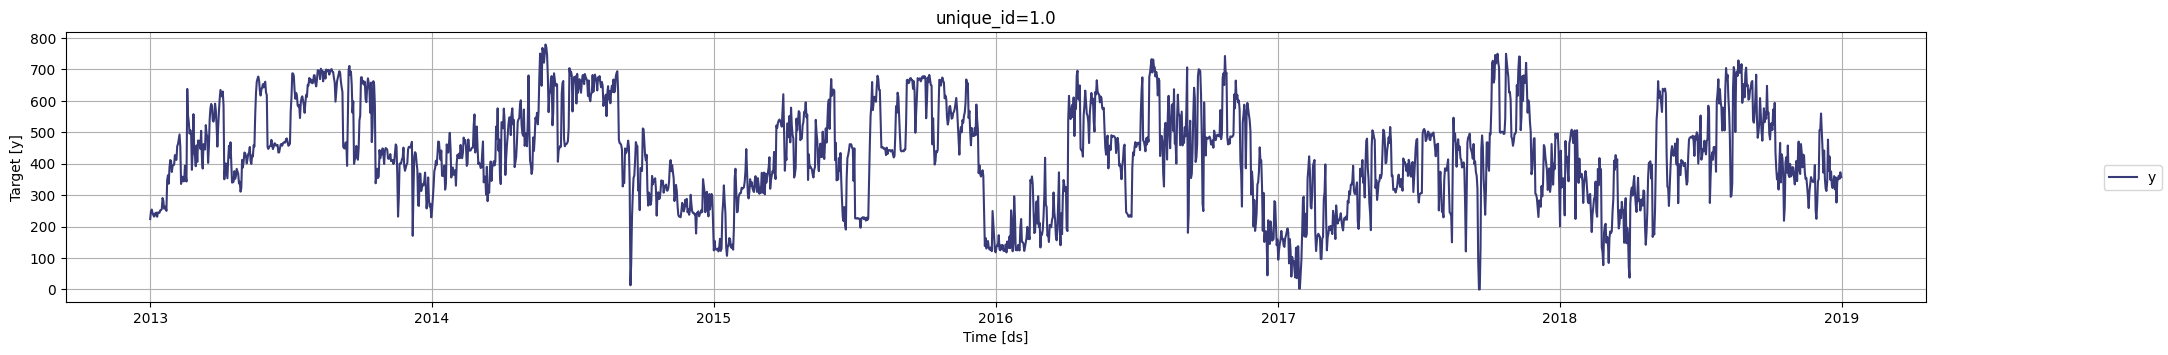

In [5]:
Y_df = df
StatsForecast.plot(Y_df)

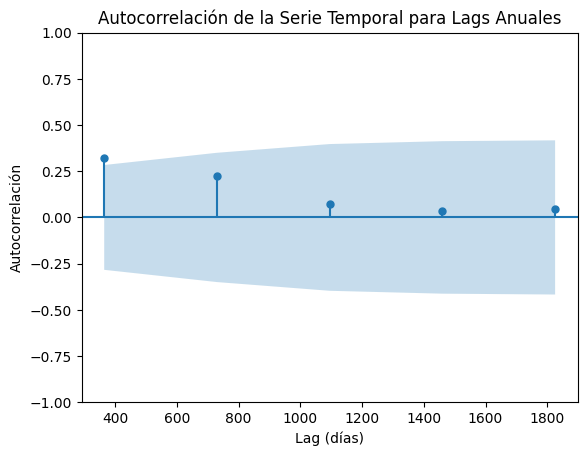

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Calcular la autocorrelación de la serie temporal para lags múltiplos del período estacional (365 días)
lags = range(365, 366*5, 365)  # Calcula la autocorrelación para lags de 365 días, 730 días, 1095 días, etc.
plot_acf(df.y, lags=lags)  # Especifica los lags a considerar
plt.xlabel('Lag (días)')
plt.ylabel('Autocorrelación')
plt.title('Autocorrelación de la Serie Temporal para Lags Anuales')
plt.show()


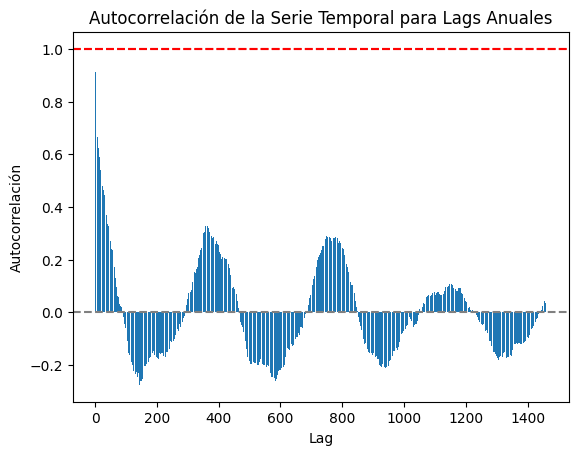

Lags significativos: []


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# Supongamos que 'serie_temporal' es tu serie temporal con 3000 datos
# serie_temporal = ...

# Calcular la autocorrelación de la serie temporal para varios lags (por ejemplo, los primeros 365 días)
lag_max = 365*4  # Establece el número máximo de lags para considerar
lags = range(1, lag_max + 1)
autocorrelation, conf_int = acf(df.y, nlags=lag_max, alpha=0.05)

# Graficar la autocorrelación junto con los intervalos de confianza
plt.bar(lags, autocorrelation[1:])
plt.xlabel('Lag')
plt.ylabel('Autocorrelación')
plt.title('Autocorrelación de la Serie Temporal para Lags Anuales')
plt.axhline(y=0, color='gray', linestyle='--')  # Línea horizontal en y=0
plt.axhline(y=conf_int[0][0], color='red', linestyle='--')  # Límite inferior del intervalo de confianza
plt.axhline(y=conf_int[0][1], color='red', linestyle='--')  # Límite superior del intervalo de confianza
plt.show()

# Identificar los lags significativos (fuera del intervalo de confianza)
significant_lags = [lags[i] for i in range(len(lags)) if autocorrelation[i] > conf_int[i][1] or autocorrelation[i] < conf_int[i][0]]
print("Lags significativos:", significant_lags)


In [8]:
# Create a list of models and instantiation parameters
season_length = 180 # seis meses
models = [
    AutoARIMA(season_length = season_length),
    SeasonalNaive(season_length=season_length),
    AutoETS(season_length = season_length),
    AutoCES(season_length = season_length),
    AutoTheta(season_length = season_length),
    ADIDA(), 
    CrostonClassic(), 
    IMAPA(), 
    TSB(alpha_d = 0.2, alpha_p = 0.2),
    GARCH(),
    ARCH()
]


In [9]:
# Instantiate StatsForecast class as sf
sf = StatsForecast( 
    models=models,
    freq='D',  # 'M'
    fallback_model = SeasonalNaive(season_length=season_length),
    n_jobs=-1,
)


In [10]:
forecasts_df = sf.forecast(df=Y_df, h=season_length, level=[90]) #
forecasts_df.head()


In [ ]:
sf.plot(Y_df,forecasts_df)

In [ ]:
# Plot to unique_ids and some selected models
sf.plot(Y_df, forecasts_df, models=["AutoARIMA","SeasonalNaive"], unique_ids=["H10", "H105"], level=[90])


In [ ]:
crossvaldation_df = sf.cross_validation(
    df=Y_df,
    h=season_length,
    step_size=season_length,
    n_windows=2
)


In [ ]:
def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals


In [ ]:
evaluation_df = evaluate_cross_validation(crossvaldation_df, mse)
evaluation_df.head()
